In [1]:
import json
import csv
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from scipy.interpolate import interp2d
from scipy.interpolate import RBFInterpolator
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pyslabgrid import polygon as poly
from pyslabgrid import reckoner as reck
from pyslabgrid import mat as mat
from pyslabgrid import slabgridding as slg

In [2]:
def get_boundpolygon(blon, blat):
    #
    dpoints = []
    for a,b in zip(blon, blat):
        dpoints.append((a, b))
    return Polygon(dpoints)

def get_interpfunc(lon, lat, dep, param):
    slon, slat, spar = ([],[],[])
    
    for i in range(len(dep)):
        if (param[i]<0) | np.isnan(param[i]):
            continue
        else:
            slon.append(float(lon[i]))
            slat.append(float(lat[i]))
            spar.append(float(param[i]))

    y = np.transpose([slon, slat])
    fintp = RBFInterpolator(y, np.array(spar), smoothing=0, kernel='linear')  
    #fintp = interp2d(np.array(slon), np.array(slat), np.array(spar), kind='linear')
    blon, blat = poly.boundary(slon, slat)
    pbounds = get_boundpolygon(blon, blat)
    
    return(fintp, pbounds)

def flatten(t):
    return [item for sublist in t for item in sublist]

In [3]:
# workout the interpolators 
def get_finterp(szone, outfile):
    slabmod = mat.getdict('../data/subduction_model/subduction_model.mat')
    izone = slabmod[szone]

    lat = flatten(izone['lat_interface']);
    lon = flatten(izone['lon_interface']);
    dep = flatten(izone['dep_interface']);

    strikeAn = flatten(izone['strikeAn']);
    if szone=='hik':
        for i in range(len(strikeAn)): 
            if strikeAn[i]<0: strikeAn[i]=230
                
    dipAn = flatten(izone['dipAn']);

    fintp_strike, pbounds = get_interpfunc(lon, lat, dep, strikeAn)
    fintp_dip, pbounds = get_interpfunc(lon, lat, dep, dipAn)
    fintp_dep, pbounds = get_interpfunc(lon, lat, dep, dep)
    
    finterp = {'strikeAn': fintp_strike, 'dipAn': fintp_dip, 
               'depth':fintp_dep, 'databounds': pbounds}
    
    np.save(outfile,finterp)
    
def get_finterp_lowerbounds(szone, interface_buffer, outfile):
    subdmod =  mat.getdict('../data/subduction_model/subduction_model.mat')
    X = mat.flatten(subdmod[szone]['lon'].tolist())
    Y = mat.flatten(subdmod[szone]['lat'].tolist())
    Z = mat.flatten(subdmod[szone]['dep'].tolist())
    lon,lat, dep = reck.shiftsheet(szone, interface_buffer,(X,Y,Z))
    finterp, pbounds = get_interpfunc(lon, lat, dep, dep)
    np.save(outfile,finterp)


In [4]:
get_finterp('hik', 'finterp/hik_finterp.npy')
get_finterp('puy', 'finterp/puy_finterp.npy');
get_finterp_lowerbounds('hik', 10, 'finterp/hik_finterp_lowerbounds.npy')
get_finterp_lowerbounds('puy', 10, 'finterp/puy_finterp_lowerbounds.npy')


##### Testing the interpolatiors
 - see test-interface-finterp

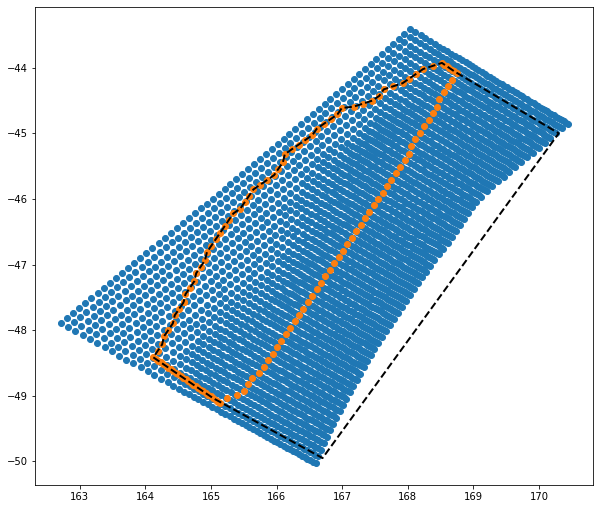

In [5]:
szone = 'puy'
X,Y,Z = slg.compute_slabgrids(szone, None, dx_km=11, doplot=False, clipzone=False)
X= mat.flatten(X)
Y =mat.flatten(Y)
subdmod =  mat.getdict('../data/subduction_model/subduction_model.mat')
finterp_file = {'hik': 'finterp/hik_finterp.npy', 'puy': 'finterp/puy_finterp.npy'}
finterp = np.load(finterp_file[szone], allow_pickle=True)[()]
pbounds = finterp['databounds']
blon, blat = pbounds.exterior.coords.xy
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(X,Y, 'o');
ax.plot(blon, blat, 'o')
xblon, xblat = [],[]
for i in range(33):
    xblon.append(blon[i])
    xblat.append(blat[i])
xblon.append(166.7)
xblat.append(-49.95)
xblon.append(170.3)
xblat.append(-45.0)
for i in range(88, len(blon)):
    xblon.append(blon[i])
    xblat.append(blat[i])
ax.plot(xblon, xblat, 'k--', linewidth=2)
ax.set_aspect('equal')

xbounds = poly.get_polygon(xblon, xblat)
finterp.update({'xbounds': xbounds})

np.save(finterp_file[szone], finterp)



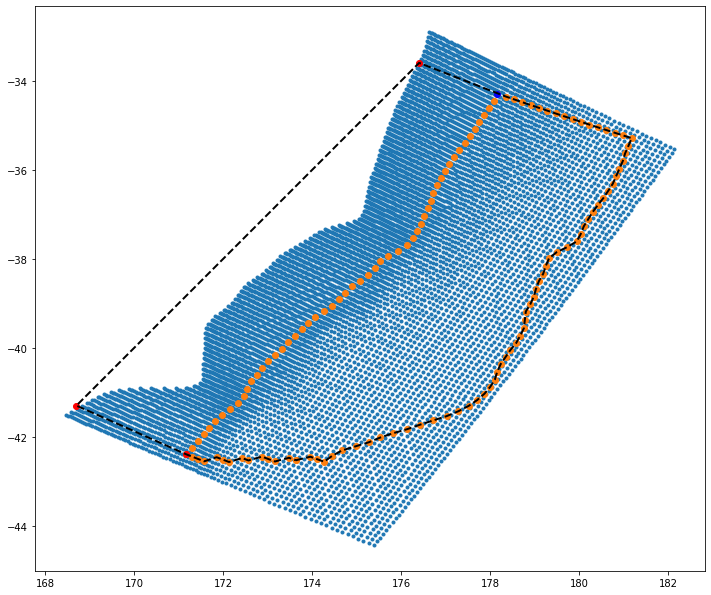

In [6]:
szone = 'hik'
X,Y,Z = slg.compute_slabgrids(szone, None, dx_km=11, doplot=False, clipzone=False)
X= mat.flatten(X)
Y =mat.flatten(Y)
subdmod =  mat.getdict('../data/subduction_model/subduction_model.mat')
finterp_file = {'hik': 'finterp/hik_finterp.npy', 'puy': 'finterp/puy_finterp.npy'}
finterp = np.load(finterp_file[szone], allow_pickle=True)[()]
pbounds = finterp['databounds']
blon, blat = pbounds.exterior.coords.xy
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(X,Y, '.');
ax.plot(blon, blat, 'o')

ax.plot(blon[68], blat[68], 'bo')
ax.plot(176.4,-33.6, 'ro')
ax.plot(168.7,-41.3, 'ro')
ax.plot(blon[122], blat[122], 'ro')

xblon, xblat = [],[]
for i in range(68):
    xblon.append(blon[i])
    xblat.append(blat[i])
xblon.append(176.4)
xblat.append(-33.6)
xblon.append(168.7)
xblat.append(-41.3)
for i in range(122, len(blon)):
    xblon.append(blon[i])
    xblat.append(blat[i])
ax.plot(xblon, xblat, 'k--', linewidth=2)
ax.set_aspect('equal')

xbounds = poly.get_polygon(xblon, xblat)
finterp.update({'xbounds': xbounds})
np.save(finterp_file[szone], finterp)